In [1]:
#please mount Google Drive in order to access the data. 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#UNZIP DATA FILE
#ATTENTION : Troubles would come from unzipping the data twice, hence the function run_once()
def run_once():
  # This 
  !unzip '/content/drive/Shared drives/Foundation of deep learning/test.zip'
  !unzip '/content/drive/Shared drives/Foundation of deep learning/train.zip'
  run_once.__code__ = (lambda: None).__code__

In [3]:
run_once()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/go/e7ea8b76_nohash_0.wav.npy  
  inflating: train/left/de89e2ca_nohash_0.wav.npy  
  inflating: train/left/11321027_nohash_0.wav.npy  
  inflating: train/yes/29229c21_nohash_1.wav.npy  
  inflating: train/yes/9f93e408_nohash_1.wav.npy  
  inflating: train/yes/d84829e0_nohash_1.wav.npy  
  inflating: train/left/40738a2d_nohash_1.wav.npy  
  inflating: train/go/0a2b400e_nohash_0.wav.npy  
  inflating: train/go/7213ed54_nohash_1.wav.npy  
  inflating: train/yes/e4be0cf6_nohash_2.wav.npy  
  inflating: train/yes/a5d485dc_nohash_2.wav.npy  
  inflating: train/yes/61ab8fbc_nohash_2.wav.npy  
  inflating: train/go/953fe1ad_nohash_4.wav.npy  
  inflating: train/yes/b9f46737_nohash_1.wav.npy  
  inflating: train/go/fa70c187_nohash_0.wav.npy  
  inflating: train/left/b308773d_nohash_3.wav.npy  
  inflating: train/yes/b487da60_nohash_0.wav.npy  
  inflating: train/yes/ccb1266b_nohash_2.wav.npy  
  inf

In [5]:
#download the required configuration
%tensorflow_version 2.x
!wget -q https://raw.githubusercontent.com/HarryMo/DeepLproject/master/requirements.txt
#!wget -q https://raw.githubusercontent.com/HarryMo/DeepLproject/master/OurModels.py

!pip install -r requirements.txt c 

###**Libraries**

In [6]:
import tensorflow as tf
import librosa
import keras
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline  

from tqdm import tqdm
import requests
import math
import os
import tarfile
import pandas as pd
import kapre
import itertools

#Libraries for the model
import tensorflow.keras
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.layers import Input, Flatten, GlobalMaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers

#Libraries to add Melspectrogram layers 
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

Using TensorFlow backend.


##**Functions**

In [0]:
def PrepareGoogleSpeechCmd(version=2, forceDownload=False, task='12cmd'):
    """
    This function will prepare the Google Speech commands dataset for the 12-commands recognition task
    """
    GSCmdV2Categs = {
        'unknown': 0,
        'silence': 1,
        '_unknown_': 0,
        '_silence_': 1,
        '_background_noise_': 1,
        'yes': 2,
        'no': 3,
        'up': 4,
        'down': 5,
        'left': 6,
        'right': 7,
        'on': 8,
        'off': 9,
        'stop': 10,
        'go': 11}
    numGSCmdV2Categs = 12

    # read split from files and all files in folders
    testWAVs = pd.read_csv('train/testing_list.txt',
                           sep=" ", header=None)[0].tolist()
    valWAVs = pd.read_csv('train/validation_list.txt',
                          sep=" ", header=None)[0].tolist()

    testWAVs = [os.path.join('train/', f + '.npy')
                for f in testWAVs if f.endswith('.wav')]
    valWAVs = [os.path.join('train/', f + '.npy')
               for f in valWAVs if f.endswith('.wav')]
    allWAVs = []
    for root, dirs, files in os.walk('train/'):
        allWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy')]
    trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

    testWAVsREAL = []
    for root, dirs, files in os.walk('test/'):
        testWAVsREAL += [root + '/' +
                         f for f in files if f.endswith('.wav.npy')]

    # get categories
    testWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in testWAVs]
    valWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in valWAVs]
    trainWAVlabels = [_getFileCategory(f, GSCmdV2Categs) for f in trainWAVs]
    testWAVREALlabels = [_getFileCategory(f, GSCmdV2Categs)
                         for f in testWAVsREAL]

    # background noise should be used for validation as well
    backNoiseFiles = [trainWAVs[i] for i in range(len(trainWAVlabels))
                      if trainWAVlabels[i] == GSCmdV2Categs['silence']]
    backNoiseCats = [GSCmdV2Categs['silence']
                     for i in range(len(backNoiseFiles))]
    if numGSCmdV2Categs == 12:
        valWAVs += backNoiseFiles
        valWAVlabels += backNoiseCats

    # build dictionaries
    testWAVlabelsDict = dict(zip(testWAVs, testWAVlabels))
    valWAVlabelsDict = dict(zip(valWAVs, valWAVlabels))
    trainWAVlabelsDict = dict(zip(trainWAVs, trainWAVlabels))
    testWAVREALlabelsDict = dict(zip(testWAVsREAL, testWAVREALlabels))

    # info dictionary
    trainInfo = {'files': trainWAVs, 'labels': trainWAVlabelsDict}
    valInfo = {'files': valWAVs, 'labels': valWAVlabelsDict}
    testInfo = {'files': testWAVs, 'labels': testWAVlabelsDict}
    testREALInfo = {'files': testWAVsREAL, 'labels': testWAVREALlabelsDict}
    gscInfo = {'train': trainInfo,
               'test': testInfo,
               'val': valInfo,
               'testREAL': testREALInfo}

    print('Done preparing Google Speech commands dataset version {}'.format(version))

    return gscInfo, numGSCmdV2Categs

In [0]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name sd_GSCmdV2/train/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [0]:
def _downloadFile(url, fName):
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024
    wrote = 0
    print('Downloading {} into {}'.format(url, fName))
    with open(fName, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=math.ceil(total_size // block_size),
                         unit='KB',
                         unit_scale=True):
            wrote = wrote + len(data)
            f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong")

In [0]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [0]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32,
                 dim=16000, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # load data from file, saved as numpy array on disk
            curX = np.load(ID)

            # normalize
            # invMax = 1/(np.max(np.abs(curX))+1e-3)
            # curX *= invMax

            # curX could be bigger or smaller than self.dim
            if curX.shape[0] == self.dim:
                X[i] = curX
            elif curX.shape[0] > self.dim:  # bigger
                # we can choose any position in curX-self.dim
                randPos = np.random.randint(curX.shape[0]-self.dim)
                X[i] = curX[randPos:randPos+self.dim]
            else:  # smaller
                randPos = np.random.randint(self.dim-curX.shape[0])
                X[i, randPos:randPos + curX.shape[0]] = curX
                # print('File dim smaller')

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [0]:
def LinearModel(nCategories, samplingrate=16000,
                      inputLength=16000):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength
    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False
    x = m(x)
    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    x = L.Permute((2, 1, 3))(x)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)


    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    x = L.Dense(256, activation='relu')(query)
    x = L.Dense(128, activation='relu')(x)
   #x = L.Dense(64, activation='relu')(x)
   #x = L.Dense(32, activation='relu')(x)
   #x = L.Dense(16, activation='relu')(x)
    output = L.Dense(nCategories, activation='softmax', name='output')(x)
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [0]:
def RNNSpeechModel(nCategories, samplingrate=16000, inputLength=16000):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = L.Input((iLen,))

    x = L.Reshape((1, -1))(inputs)

    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')(x)

    x = Normalization2D(int_axis=0)(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(
        x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(L.LSTM(64))(x)

    x = L.Dense(64, activation='relu')(x)
    x = L.Dense(32, activation='relu')(x)

    output = L.Dense(nCategories, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [0]:
def ConvSpeechModel(nCategories, samplingrate=16000, inputLength=16000):
    inputs = L.Input((inputLength,))

    x = L.Reshape((1, -1))(inputs)

    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, inputLength),
                       padding='same', sr=samplingrate, n_mels=80,
                       fmin=40.0, fmax=samplingrate / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')(x)

    x = Normalization2D(int_axis=0)(x)
    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)
    #x = Reshape((94,80))(x) #this is strange - but now we have (batch_size,
    # sequence, vec_dim)

    c1 = L.Conv2D(20, (5, 1), activation='relu', padding='same')(x)
    c1 = L.BatchNormalization()(c1)
    p1 = L.MaxPooling2D((2, 1))(c1)
    p1 = L.Dropout(0.03)(p1)

    c2 = L.Conv2D(40, (3, 3), activation='relu', padding='same')(p1)
    c2 = L.BatchNormalization()(c2)
    p2 = L.MaxPooling2D((2, 2))(c2)
    p2 = L.Dropout(0.01)(p2)

    c3 = L.Conv2D(80, (3, 3), activation='relu', padding='same')(p2)
    c3 = L.BatchNormalization()(c3)
    p3 = L.MaxPooling2D((2, 2))(c3)

    p3 = L.Flatten(data_format=None)(p3)
    p3 = L.Dense(64, activation='relu')(p3)
    p3 = L.Dense(32, activation='relu')(p3)

    output = L.Dense(nCategories, activation='softmax')(p3)

    model = Model(inputs=[inputs], outputs=[output], name='ConvSpeechModel')

    return model

In [0]:
def ConvModel(nCategories, samplingrate=16000, inputLength=16000):
   # simple LSTM
    sr = samplingrate
    iLen = inputLength
    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Lambda(lambda q: K.squeeze(q, -1))(x)
    
    query = L.Dense(64)(x)

    x = L.Dense(32, activation='relu')(query)
    x = L.Dense(32, activation='relu')(x)
    output = L.Dense(nCategories, activation='softmax', name='output')(x)
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [0]:
def RNNConvModel(nCategories, samplingrate=16000,
                      inputLength=16000):
   # simple LSTM
    sr = samplingrate
    iLen = inputLength
    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1))(x)

    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(32))(x) 

    #y = L.Lambda(lambda q: q[:, -1])(x)  

    query = L.Dense(128)(x)

    x = L.Dense(64, activation='relu')(query)
    x = L.Dense(32, activation='relu')(x)
    output = L.Dense(nCategories, activation='softmax', name='output')(x)
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [0]:
def AttentionRNNConvModel(nCategories, samplingrate=16000,
                      inputLength=16000):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength
    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)
    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 5), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1))(x)

    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(32, return_sequences=True))(x) 

    y = L.Lambda(lambda q: q[:, -1])(x)  

    query = L.Dense(64)(y)
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]
    
    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32, activation='relu')(x)
    output = L.Dense(nCategories, activation='softmax', name='output')(x)
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [64]:
#prepare all data
gscInfo, nCategs = PrepareGoogleSpeechCmd(version=2, task = '12cmd')

Done preparing Google Speech commands dataset version 2


##**Speech Data Generator**

In [28]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
30769
12


In [29]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = DataGenerator(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = DataGenerator(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = DataGenerator(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = DataGenerator(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

115

In [30]:
audios, classes = valGen.__getitem__(34)
classes

array([11,  8, 10,  9,  6,  7, 11,  9, 10,  6,  5, 11, 10, 10,  3,  7,  4,
        5, 11, 11,  5,  2,  6,  3,  2,  8,  7,  2, 11,  7,  9,  5])

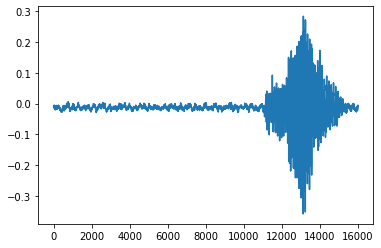

In [31]:
librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [32]:
melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft'))

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [33]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

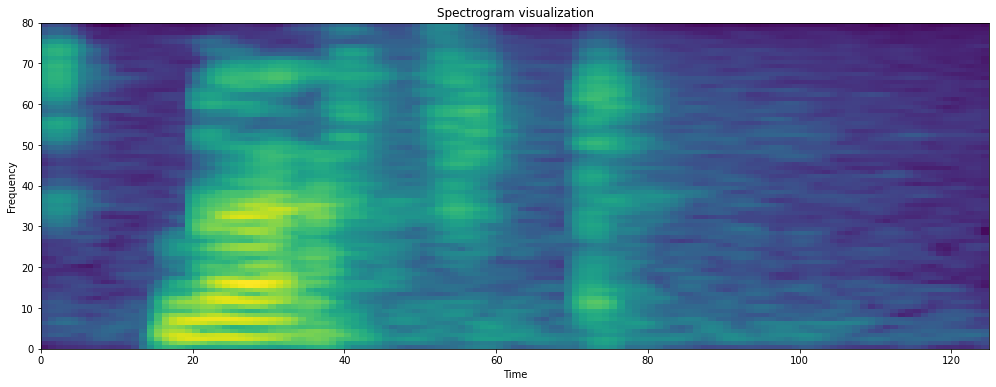

In [34]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [0]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

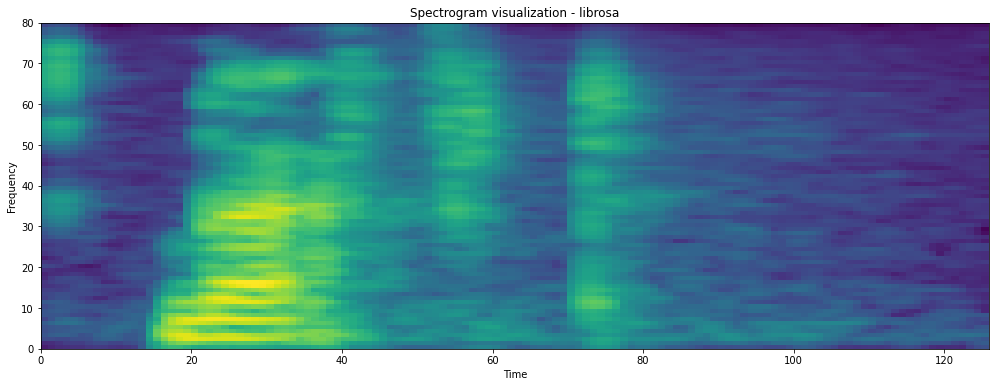

In [36]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

##**Models**

Create Keras models to see if the generators are working properly

In [65]:
nCategs=12

#model = LinearModel(nCategs, samplingrate = 16000, inputLength = 16000)
#model = ConvModel(nCategs, samplingrate = 16000, inputLength = 16000)
#model = ConvSpeechModel(nCategs, samplingrate = 16000, inputLength = 16000)
model = RNNConvModel(nCategs, samplingrate = 16000, inputLength = 16000)
#model = RNNSpeechModel(nCategs, samplingrate = 16000, inputLength = 16000)
#model = AttentionRNNConvModel(nCategs, samplingrate = 16000, inputLength = 16000)


model.compile(optimizer='Adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16000)]           0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 1, None)           0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, None, 1)       1091664   
_________________________________________________________________
mel_stft_norm (Normalization (None, 80, None, 1)       0         
_________________________________________________________________
permute_14 (Permute)         (None, None, 80, 1)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, 80, 1)       26        
_________________________________________________________________
batch_normalization_26 (Batc (None, None, 80, 1)       4   

In [0]:
# model.load_weights('model-attRNN.h5')

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate

In [0]:
lrate = LearningRateScheduler(step_decay)

In [0]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)

checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=10, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])


model.save('model-attRNN.h5')

Changing learning rate to 0.01
Epoch 1/10

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.57418, saving model to model-attRNN.h5
961/961 - 142s - loss: 1.4337 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.1114 - val_sparse_categorical_accuracy: 0.5742 - lr: 0.0100
Changing learning rate to 0.01
Epoch 2/10

Epoch 00002: val_sparse_categorical_accuracy improved from 0.57418 to 0.63071, saving model to model-attRNN.h5
961/961 - 141s - loss: 0.8901 - sparse_categorical_accuracy: 0.6936 - val_loss: 1.1022 - val_sparse_categorical_accuracy: 0.6307 - lr: 0.0100
Changing learning rate to 0.01
Epoch 3/10

Epoch 00003: val_sparse_categorical_accuracy improved from 0.63071 to 0.82391, saving model to model-attRNN.h5
961/961 - 141s - loss: 0.7081 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.5814 - val_sparse_categorical_accuracy: 0.8239 - lr: 0.0100
Changing learning rate to 0.01
Epoch 4/10

Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.8239

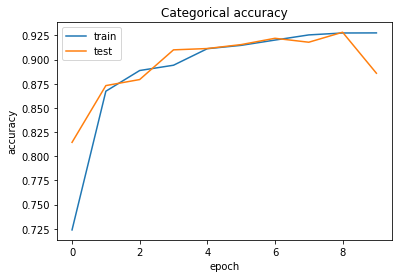

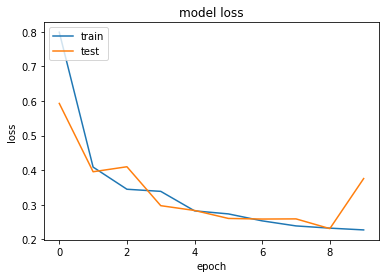

In [0]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# results.history

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [0]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.33185040950775146, 0.8947710990905762] 
Validation: [0.3790127635002136, 0.886141300201416] 
Test: [0.39690786600112915, 0.8743249773979187]


##**Confusion Matrix**

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])

In [0]:
audios, classes = valGen.__getitem__(3)
classes

array([10,  6,  4,  3, 11,  9,  9,  7, 10,  9,  6, 11,  9,  3, 11,  8,  3,
       10,  4,  7,  9,  6,  3,  7, 10,  6,  2,  8,  8,  5,  4, 11])

In [0]:
#8 - on, 13 - one, 7 - right
idAudio = 7
classes[idAudio]

7

In [0]:
outs, attW, specs = attSpeechModel.predict(audios)

In [0]:
np.argmax(outs,axis=1)

array([10,  6,  4,  3, 11,  4,  9,  7, 10,  4, 10, 11,  9,  3, 11,  8,  3,
       10,  4,  7,  4,  6,  6,  7, 10,  6,  2,  8,  8,  5,  4, 11])

In [0]:
specs.shape

(32, 80, 125, 1)

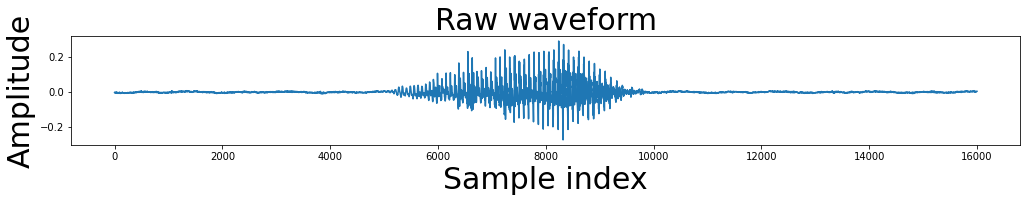

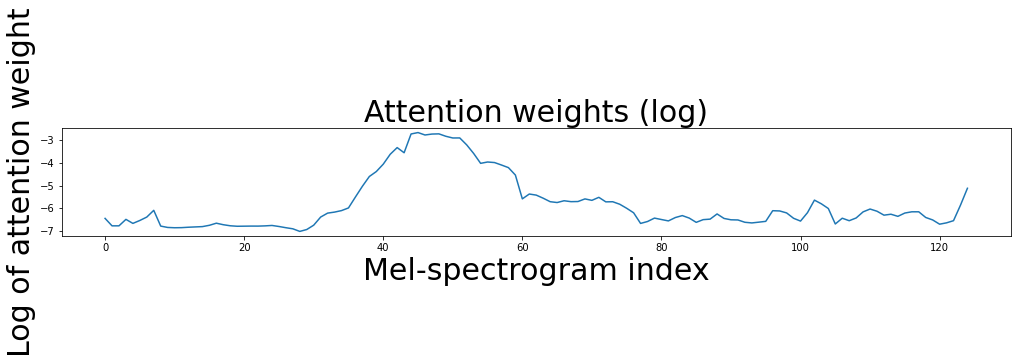

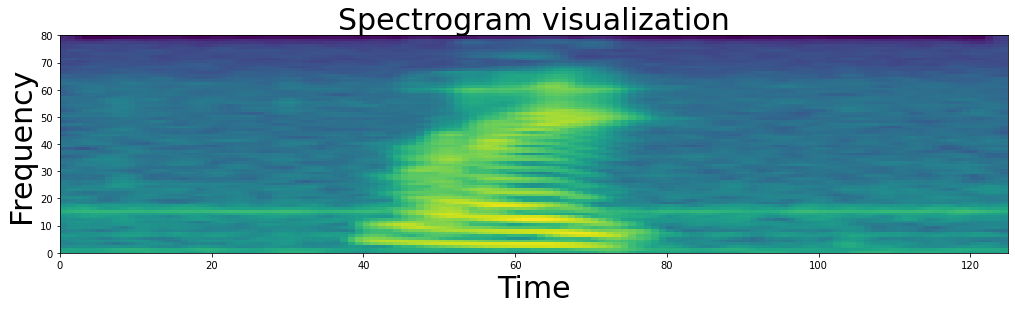

In [0]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [0]:
y_pred = model.predict(x_test, verbose=1)

128/128 [==============================] - 2s 17ms/step


In [0]:
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
#class 12cmd
classes = ['yes','no','up','down','left','right','on','off','stop','go']

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig('picConfMatrix.png', dpi=400)
    plt.tight_layout()

Confusion matrix, without normalization


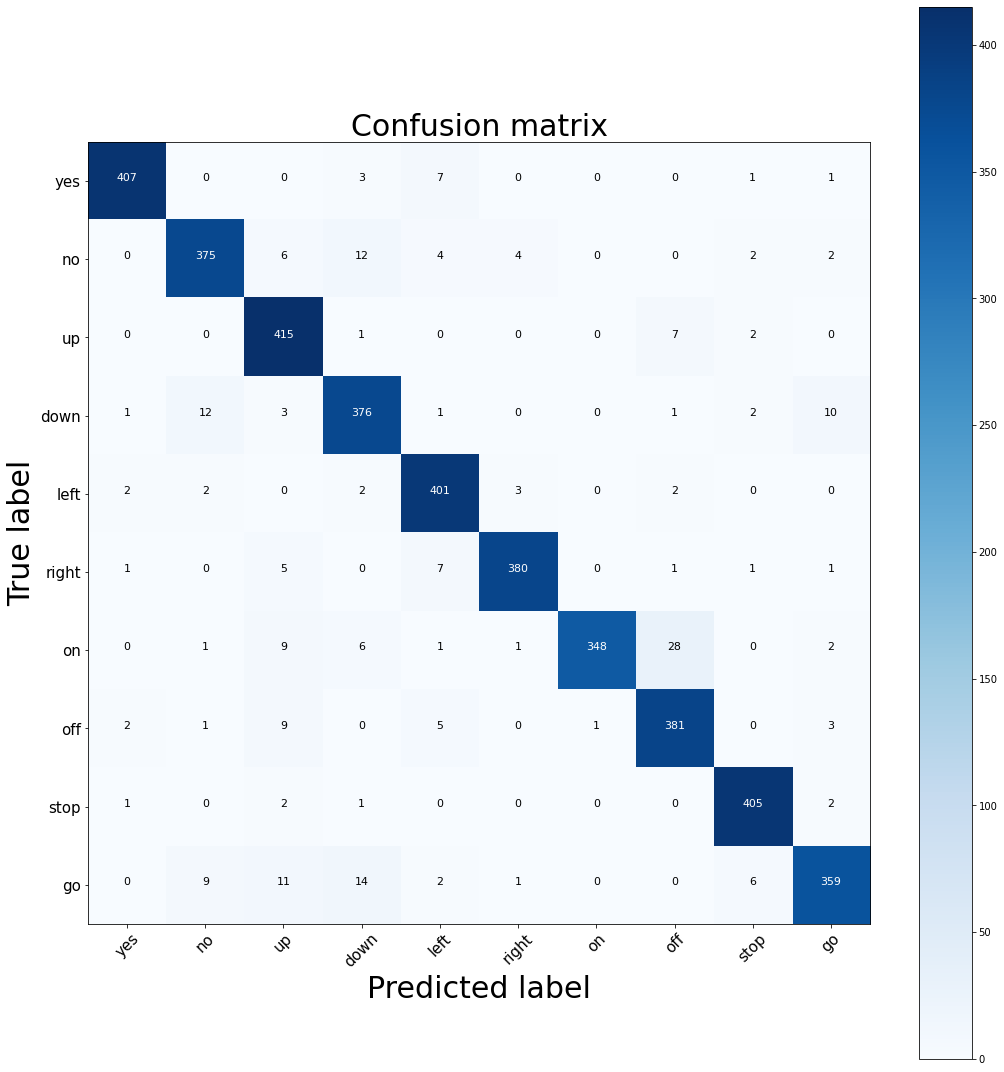

In [0]:
plot_confusion_matrix(cm,classes, normalize=False)